# Bank Customer Churn - Random Forest Classifier

In [1]:
#pip install plotnine

In [2]:
import pandas as pd
import numpy as np
from datetime import date
import scipy.special
import scipy.stats as stats
from collections import Counter

In [3]:
# Viz
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
from plotnine import *

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

In [6]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [7]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc 
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve

In [8]:
import warnings
warnings.filterwarnings('ignore') # no more warnings 

In [9]:
pd.set_option('display.max_columns', None)

# Getting the data

#### Reading the file

In [11]:
#df = pd.read_csv("../data/Bank Customer Churn Prediction.csv", sep = ',')
df = pd.read_csv("../data/Bank Customer Churn Prediction without outliers.csv", index_col=0) # BETTER F1-Score
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [12]:
# we drop "customer_id" as it isn't relevant for our analysis
#df.drop('customer_id', inplace=True, axis=1)
#df.head()

In [13]:
# based on the future importance we drop "credit_card" to analysis the impact: NO IMPACT
#df.drop('credit_card', inplace=True, axis=1)
#df.head()

In [14]:
df.columns

Index(['credit_score', 'country', 'gender', 'age', 'tenure', 'balance',
       'products_number', 'credit_card', 'active_member', 'estimated_salary',
       'churn'],
      dtype='object')

## Encoders

In [15]:
#encoder1 = OneHotEncoder()
encoder2 = LabelEncoder()
encoder3 = OrdinalEncoder()
#encoder4 = get_dummies()

In [16]:
encoder = encoder3.fit(df['country'])
df['country'] = encoder.transform(df['country'])

encoder = encoder3.fit(df['gender'])
df['gender'] = encoder.transform(df['gender'])

> There is not impact between encoders

# Modelling - Random Forest Classifier

#### Separating the data (identify Independant features and target)

In [17]:
X= df.drop("churn", axis=1)
y = df["churn"]

In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   country           10000 non-null  int32  
 2   gender            10000 non-null  int32  
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   products_number   10000 non-null  int64  
 7   credit_card       10000 non-null  int64  
 8   active_member     10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
dtypes: float64(2), int32(2), int64(6)
memory usage: 781.2 KB


In [19]:
type(X)

pandas.core.frame.DataFrame

#### Split Train and test data set

In [20]:
# play with text_size
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, random_state=0) # Model learn better

Check the **distribution of labels**:

In [21]:
pd.DataFrame(y).value_counts(normalize=True)

churn
0        0.7963
1        0.2037
dtype: float64

In [22]:
pd.DataFrame(y_train).value_counts(normalize=True)

churn
0        0.796
1        0.204
dtype: float64

In [23]:
pd.DataFrame(y_test).value_counts(normalize=True)

churn
0        0.7975
1        0.2025
dtype: float64

### Hyperparameters controlling Random forests and the underlying Decision trees:
- `max_features`: number of features that will be used in each split ($\sqrt{\mathrm{n\_features}}$ for classification)
- `n_estimators`: number of estimators (should be >= 100)
- `max_depth`: maximum depth of the tree
- `max_leaf_nodes`: maximum number of leaf nodes allowed in the tree
- `min_samples_split`: minimum number of samples required to split a node
- `min_impurity_decrease`: minimum decrease of the impurity for required to split a node
- `oob_score`: hether to use out-of-bag samples to estimate the generalization score. Only available if bootstrap=True.
- `class_weight`: Weights associated with classes in the form {class_label: weight}.
- `criterion`: The function to measure the quality of a split.

#### Managing imbalance dataset

In [24]:
#### managing imbalance dataset: ponderate the weight of the churns (4 more times)
dictionary={0:1, 1:4}

#### GridSearchCV

In [25]:
#param = {'n_estimators':[50, 150, 200, 300], 'criterion': ['gini', 'entropy', 'log_loss'], 'min_samples_split': [2, 5, 10], 'max_leaf_nodes':[10, 25, 50]}
param = {'n_estimators':[50, 150, 200, 300], 'criterion': ['gini', 'entropy', 'log_loss']}

In [38]:
#model=GridSearchCV(RandomForestClassifier(class_weight=dictionary, random_state = 0, oob_score=True, max_leaf_nodes=50),param_grid=param)
model=GridSearchCV(RandomForestClassifier(class_weight=dictionary, random_state = 0),param_grid=param)
model.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(class_weight={0: 1, 1: 4},
                                              random_state=0),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'n_estimators': [50, 150, 200, 300]})

In [39]:
best_model = model.best_estimator_
print("n_estimators", model.best_params_)

n_estimators {'criterion': 'entropy', 'n_estimators': 300}


In [40]:
# instance of the model with best estimator
classifier = best_model.fit(X_train, y_train)

In [41]:
print("score on train set:", classifier.score(X_train, y_train))
print("score on test set:", classifier.score(X_test, y_test))

score on train set: 1.0
score on test set: 0.87


In [42]:
#classifier = RandomForestClassifier(class_weight=dictionary, random_state = 0, oob_score=True, n_estimators=200, criterion='entropy')
#classifier = RandomForestClassifier(class_weight=dictionary, random_state = 0,  n_estimators=300, oob_score=True)
#classifier.fit(X_train, y_train)

After fitting, all individual estimators are stored in the `.estimators_` attribute:

In [43]:
classifier.estimators_[:10]

[DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                        random_state=209652396),
 DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                        random_state=398764591),
 DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                        random_state=924231285),
 DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                        random_state=1478610112),
 DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                        random_state=441365315),
 DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                        random_state=1537364731),
 DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                        random_state=192771779),
 DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                        random_state=1491434855),
 DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
           

### Evaluation of the quality of the model.

#### Predict the label for new data

In [44]:
y_pred = classifier.predict(X_test)

In [45]:
accuracy_train = classifier.score(X_train, y_train)
print(f"Accuracy on the training set: {accuracy_train:.0%}")

Accuracy on the training set: 100%


In [46]:
accuracy_test = classifier.score(X_test, y_test)
print(f"Accuracy on the test set: {accuracy_test:.0%}")

Accuracy on the test set: 87%


Check the confusion matrix:

In [47]:
matrix = confusion_matrix(y_test, y_pred)
matrix

array([[1529,   66],
       [ 194,  211]], dtype=int64)

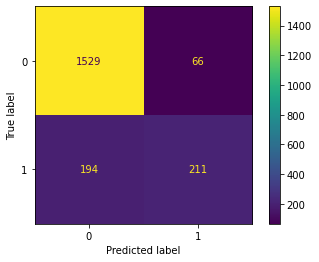

In [48]:
fig, ax = plt.subplots(constrained_layout=False)
plot_confusion_matrix(classifier, X_test, y_test, ax=ax)
ax.grid(b=False);

> Grid Search
* True Positives - 1529
* False Positives - 211
* True Negatives - 194
* False Negatives - 66

Get the classification report:

In [50]:
target_names = ['Not Churn','Churn']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Not Churn       0.89      0.96      0.92      1595
       Churn       0.76      0.52      0.62       405

    accuracy                           0.87      2000
   macro avg       0.82      0.74      0.77      2000
weighted avg       0.86      0.87      0.86      2000



> F1 Score is the Harmonic Mean of Precision and Recall.
> The simple mean will treat all values equally, but Harmonic mean gives more weight to low values


> Insights
> * different encoders doesn't affect to the model
> * without outliers (75% with outliers)
> * criterion: entropy (or measure of disorder) or gini (by default)
> * n_estimators: 200 or 300
> * F1-score (macro avg): 77%

Predict the probabilities of each label for new data with `.predict_proba()`:

In [51]:
classifier.classes_

array([0, 1], dtype=int64)

In [52]:
probabilities = classifier.predict_proba(X_test)

In [53]:
probabilities[:10]

array([[0.67333333, 0.32666667],
       [0.8       , 0.2       ],
       [0.9       , 0.1       ],
       [0.98      , 0.02      ],
       [0.99333333, 0.00666667],
       [0.27      , 0.73      ],
       [0.94      , 0.06      ],
       [0.91      , 0.09      ],
       [0.84333333, 0.15666667],
       [0.24      , 0.76      ]])

In [54]:
probabilities = pd.DataFrame(probabilities)

In [55]:
probabilities.columns = classifier.classes_

In [56]:
probabilities.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [57]:
probabilities = pd.concat([probabilities, y_test],axis=1)

In [58]:
probabilities.head(30)

,0,1,churn
0,0.673333,0.326667,0
1,0.800000,0.200000,1
2,0.900000,0.100000,0
3,0.980000,0.020000,0
4,0.993333,0.006667,0
5,0.270000,0.730000,1
6,0.940000,0.060000,0
7,0.910000,0.090000,0
8,0.843333,0.156667,1
9,0.240000,0.760000,1


### ROC and AUC curves

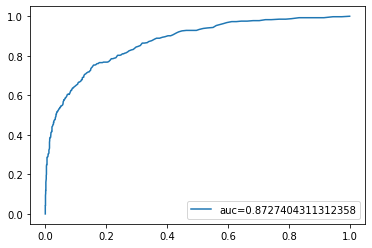

In [59]:
y_pred_proba = classifier.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()

AUC score for the case is 0.87. AUC score 1 represents a perfect classifier, and 0.5 represents a worthless classifier.

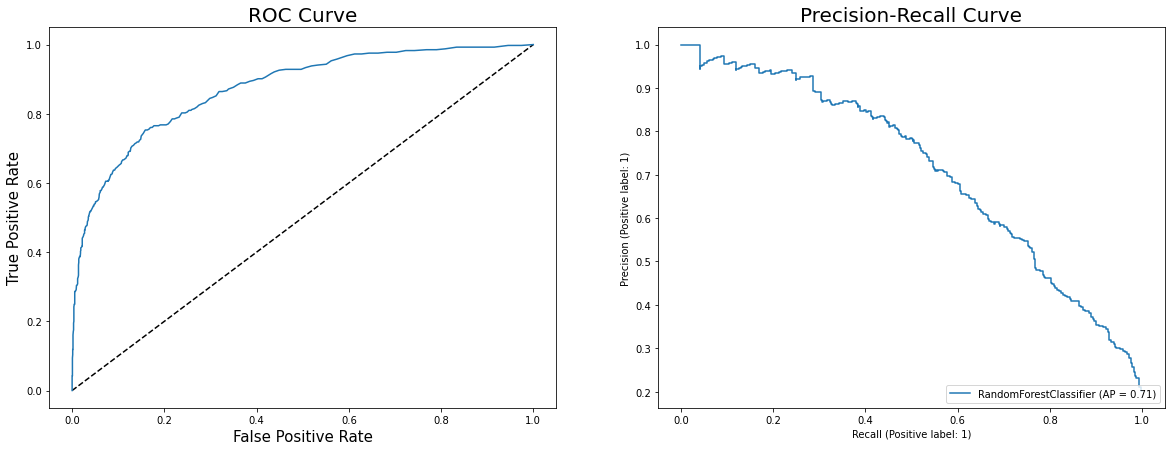

In [60]:
plt.figure(figsize = (20,7))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.plot([0,1],[0,1],'k--') 
#ax1.plot(fpr,tpr,label="data 1, auc="+str(auc))
ax1.plot(fpr,tpr,label=auc)

ax1.set_xlabel('False Positive Rate', fontsize = 15)
ax1.set_ylabel('True Positive Rate', fontsize = 15)
ax1.set_title('ROC Curve', fontsize = 20)

plot_precision_recall_curve(classifier, X_test, y_test, ax = ax2)
ax2.set_title("Precision-Recall Curve", fontsize = 20)

plt.legend(loc=4)
plt.show()

In this case we have a very imbalanced dataset and then we rely on the precision-recall curve, which shows the trade-off between precision and recall of our model. In fact, we see that the ROC curve presents a rather optimistic view on the performance of the model (high area under the curve) while the precision-recall doesn't. 

## Feature Importance

The model also contains **an estimation** of the feature importances (`.feature_importances_`):

In [61]:
classifier.feature_importances_

array([0.14501696, 0.0426511 , 0.02227408, 0.23422277, 0.08513821,
       0.14786529, 0.11946356, 0.01956475, 0.03243109, 0.1513722 ])

The feature importances in a Random forest is the sum of the feature importances of the individual Decision trees:

In [62]:
feature_importances = sum(dt.feature_importances_ for dt in classifier.estimators_)

In [63]:
feature_importances

array([43.50508755, 12.79532868,  6.68222354, 70.26682958, 25.54146162,
       44.35958824, 35.83906789,  5.86942386,  9.72932829, 45.41166075])

In [64]:
feature_importances / feature_importances.sum()

array([0.14501696, 0.0426511 , 0.02227408, 0.23422277, 0.08513821,
       0.14786529, 0.11946356, 0.01956475, 0.03243109, 0.1513722 ])

Plot the feature_importances_ (based on mean decrease in impurity):

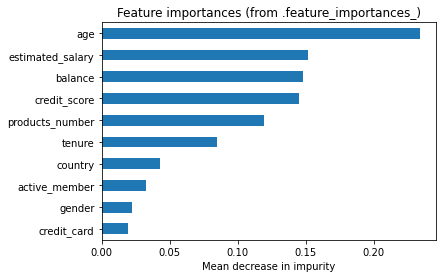

In [80]:
fig, ax = plt.subplots()
feature_importances = classifier.feature_importances_
feature_names = X.columns
dt_feature_importances = pd.Series(feature_importances, index=feature_names)
dt_feature_importances = dt_feature_importances.sort_values()
dt_feature_importances.plot.barh(ax=ax)

ax.set_title("Feature importances (from .feature_importances_)")
ax.set_xlabel("Mean decrease in impurity");

In [81]:
classifier.feature_importances_

array([0.14501696, 0.0426511 , 0.02227408, 0.23422277, 0.08513821,
       0.14786529, 0.11946356, 0.01956475, 0.03243109, 0.1513722 ])

In [82]:
df_feature_importancex=pd.DataFrame({"feature": X_train.columns, "importance": feature_importances}).sort_values('importance', ascending=False)
df_feature_importance=aux.sort_values('importance', ascending=False)
df_feature_importance

,feature,importance
3,age,0.234223
9,estimated_salary,0.151372
5,balance,0.147865
0,credit_score,0.145017
6,products_number,0.119464
4,tenure,0.085138
1,country,0.042651
8,active_member,0.032431
2,gender,0.022274
7,credit_card,0.019565


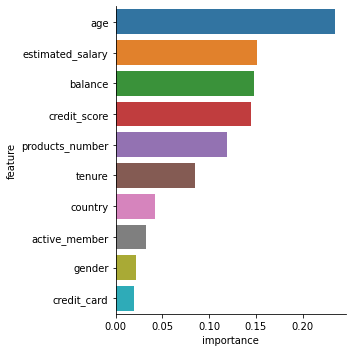

In [84]:
sns.catplot(
    data=df_feature_importancex, x='importance', y='feature',
    kind="bar"
)

In [85]:
dt_feature_importances.shape

(10,)

The feature importances in a Random forest is the sum of the feature importances of the individual Decision trees:

In [86]:
classifier.estimators_[:10]

[DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                        random_state=209652396),
 DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                        random_state=398764591),
 DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                        random_state=924231285),
 DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                        random_state=1478610112),
 DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                        random_state=441365315),
 DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                        random_state=1537364731),
 DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                        random_state=192771779),
 DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                        random_state=1491434855),
 DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
           

Visualize the most important features

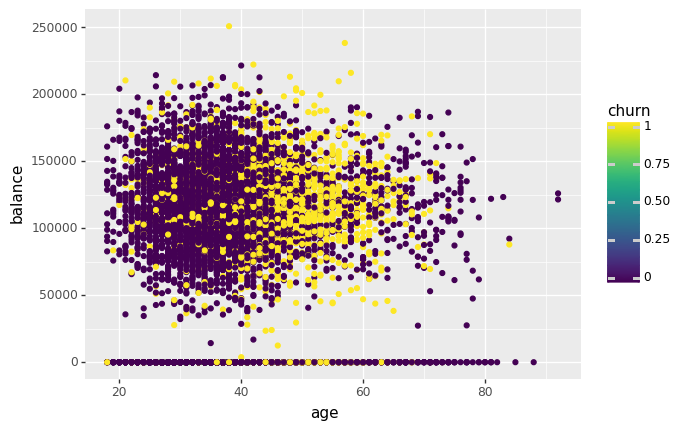

<ggplot: (152159790065)>

In [87]:
ggplot(aes(x='age',y='balance', color='churn'),df) + geom_point(stat='identity')

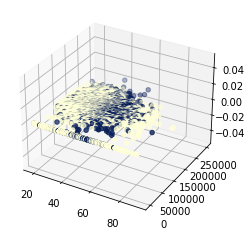

In [88]:
chart3d = plt.axes(projection='3d')
chart3d.scatter3D(df.age, df.balance, c=df.churn, cmap="YlGnBu")

# Summary

## Random Forest Classifier

### Advantages:
- Both **training stage and prediction stage are very fast** (thanks to the simplicity of decision trees and parallelization)
- The majority vote among estimators gives an estimate of the **probability**
- The model is **extremely flexible**, and can thus perform well on tasks that are under-fit by other estimators
- The model works **without any preprocessing** (if the number of estimators is large enough)

###  Disadvantages:
- The results are not easily interpretable